In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap
import optax
from diffrax import diffeqsolve, ODETerm, Dopri5

#### Stochastic interpolants example

In [60]:
num_target = 1000
key = jax.random.PRNGKey(10)
target_samples = jax.random.uniform(key,shape = (10*num_target,2),minval=-1,maxval=1)
target_samples = 5 * target_samples[jnp.sum(jnp.abs(target_samples),1)>0.5][:num_target]

In [61]:
num_reference = 1000
key = jax.random.PRNGKey(15)
reference_samples = jax.random.normal(key=key,shape=(num_reference,2))

In [70]:
class NeuralNetwork(eqx.Module):
    layers: list
    extra_bias: jax.Array

    def __init__(self, key):
        key1, key2, key3 = jax.random.split(key, 3)
        # These contain trainable parameters.
        self.layers = [eqx.nn.Linear(3, 256, key=key1),
                       jax.nn.relu,
                       eqx.nn.Linear(256, 256, key=key2),
                       jax.nn.relu,
                       eqx.nn.Linear(256, 2, key=key3)]
        # This is also a trainable parameter.
        self.extra_bias = jax.numpy.ones(2)

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return self.layers[-1](x) + self.extra_bias
    
def I(t,x,y):
    return (1-t)*x + t*y

def It(x,y):
    return -x + y

def gamma(t):
    return jnp.sqrt(2*t*(1-t))

gammadot = vmap(vmap(grad(gamma)))

@eqx.filter_jit  # compile this function to make it run fast.
# @eqx.filter_grad  # differentiate all floating-point arrays in `model`.
def loss(model, t, x, y, z):
    tx = jnp.hstack([t.reshape(-1,1),I(t,x,y)])
    bhat = jax.vmap(model)(tx)  # vectorise the model over a batch of data


    #loss_value = jnp.mean(jnp.sum(bhat**2,axis=1))
    #dot_term = jnp.mean(jnp.sum((It(x,y) + gammadot(t)*z)*bhat,axis=1))
    #dot_term = 2 * jnp.mean(jnp.sum((It(x,y))*bhat,axis=1))
    #return loss_value - dot_term
    return jnp.mean((bhat - (It(x,y) + gammadot(t)*z))**2)

In [71]:
t = jax.random.uniform(jax.random.PRNGKey(3),(1000,1))
z = jax.random.normal(jax.random.PRNGKey(4),(1000,2))
model = NeuralNetwork(jax.random.PRNGKey(0))
loss(model,t,reference_samples,target_samples,z)

Array(14.839146, dtype=float32)

In [73]:
def evaluate(model, testloader):
    avg_loss = 0
    for t,x,y,z in testloader:
        avg_loss += loss(model,t,x,y,z)
    return avg_loss / 100

In [74]:
def get_trainloader():
    for i in range(10**8):
        trainloader_key = jax.random.PRNGKey(i)
        shuffle_ref_key,shuffle_target_key,normal_key,t_key = jax.random.split(trainloader_key,4)

        ref_batch = jax.random.permutation(shuffle_ref_key,reference_samples)
        
        target_batch = jax.random.permutation(shuffle_target_key,target_samples)

        t_vals = jax.random.uniform(t_key,(len(ref_batch),1))

        z = jax.random.normal(normal_key,ref_batch.shape)

        yield t_vals,ref_batch,target_batch,z

def get_testloader():
    for i in range(100):
        testloader_key = jax.random.PRNGKey(1000*i)
        shuffle_ref_key,shuffle_target_key,normal_key,t_key = jax.random.split(testloader_key,4)
        ref_batch = jax.random.permutation(shuffle_ref_key,reference_samples)
        target_batch = jax.random.permutation(shuffle_target_key,target_samples)
        t_vals = jax.random.uniform(t_key,(len(ref_batch),1))
        z = jax.random.normal(normal_key,ref_batch.shape)
        yield t_vals,ref_batch,target_batch,z

In [81]:
learning_rate = 1e-4
optim = optax.adam(learning_rate=learning_rate)
trainloader = get_trainloader()

In [82]:
def train(
  model: NeuralNetwork,
  optim,
  steps,
  print_every
)  -> NeuralNetwork:
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    #@eqx.filtered_jit
    @eqx.filter_jit
    def make_step(
        model,
        opt_state,
        t,
        x,
        y,
        z
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model,t,x,y,z)
        updates, opt_state = optim.update(grads,opt_state,model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
        
    testloader = get_testloader()
    for step, (t,x,y,z) in zip(range(steps), trainloader):
        model, opt_state, train_loss = make_step(model, opt_state, t,x,y,z)
        if (step % print_every) == 0 or (step == steps - 1):
            test_loss = evaluate(model, testloader)
            print("step=" + str(step) + " | train_loss=" + str(train_loss))
            print("test_loss=" + str(test_loss))

    return model
                

In [83]:
model = train(model,optim,steps=5000,print_every=250)

step=0 | train_loss=14.978024
test_loss=14.769881
step=250 | train_loss=10.238179
test_loss=0.0
step=500 | train_loss=13.282115
test_loss=0.0
step=750 | train_loss=10.104281
test_loss=0.0
step=1000 | train_loss=13.959325
test_loss=0.0
step=1250 | train_loss=10.961985
test_loss=0.0
step=1500 | train_loss=13.845929
test_loss=0.0
step=1750 | train_loss=16.571033
test_loss=0.0
step=2000 | train_loss=30.160183
test_loss=0.0
step=2250 | train_loss=10.602837
test_loss=0.0
step=2500 | train_loss=9.885591
test_loss=0.0
step=2750 | train_loss=8.105473
test_loss=0.0
step=3000 | train_loss=16.433693
test_loss=0.0
step=3250 | train_loss=9.780222
test_loss=0.0
step=3500 | train_loss=12.932456
test_loss=0.0
step=3750 | train_loss=33.41379
test_loss=0.0
step=4000 | train_loss=9.034293
test_loss=0.0
step=4250 | train_loss=13.014208
test_loss=0.0
step=4500 | train_loss=12.957926
test_loss=0.0
step=4750 | train_loss=10.6379595
test_loss=0.0
step=4999 | train_loss=32.54884
test_loss=0.0


In [84]:
vmapped_model = vmap(model)
def dX_t(t,x,args):
    t_vec = jnp.ones((len(x),1))*t
    return vmapped_model(jnp.hstack([t_vec,x]))

In [85]:
X0 = reference_samples.copy()
X = X0.copy()
X_hist = []
t = 0
for i in range(100):

    X += 0.01 * dX_t(t,X,None)
    t+=0.01
    X_hist.append(X)

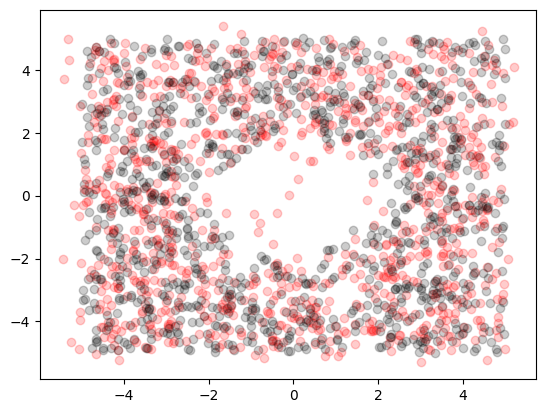

In [87]:
plt.scatter(X[:,0],X[:,1],c='red',alpha = 0.2)
plt.scatter(target_samples[:,0],target_samples[:,1],c='black',alpha = 0.2)


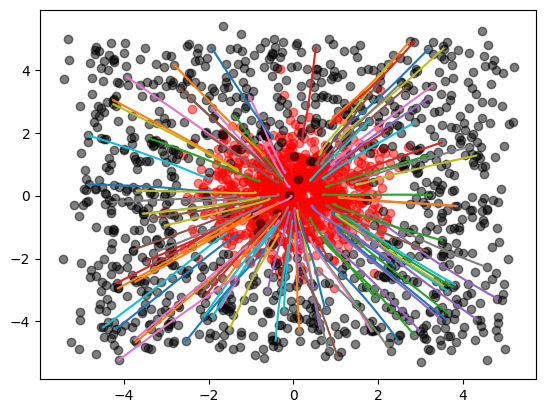

In [90]:
X_hist = jnp.array(X_hist)
plt.scatter(X0[:,0],X0[:,1],c='red',alpha = 0.5)
plt.scatter(X[:,0],X[:,1],c='black',alpha = 0.5)

for i in range(100):
    plt.plot(X_hist[:,i,0],X_hist[:,i,1])

In [48]:
term = ODETerm(dX_t)
solver = Dopri5()
X0 = reference_samples
solution = diffeqsolve(term, solver, t0=0, t1=0.99, dt0=0.01, y0=X0)

In [49]:
sol_samples = solution.ys[0]

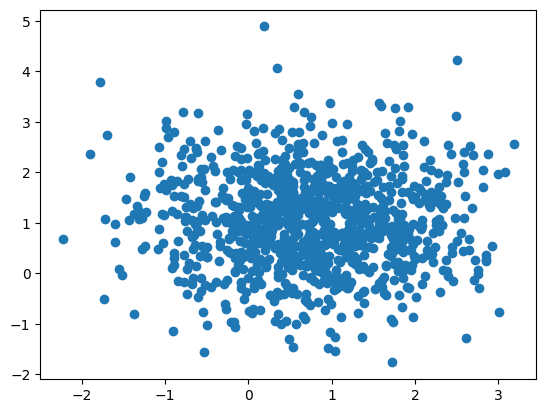

In [50]:
plt.scatter(sol_samples[:,0],sol_samples[:,1])

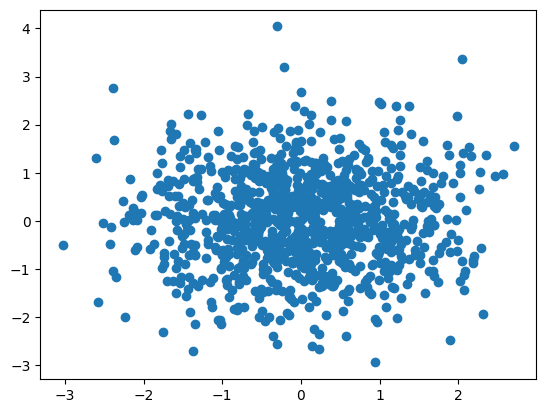

In [51]:
plt.scatter(X0[:,0],X0[:,1])